# Import modules

In [1]:
seed = 42 # random state set for reproducibility

# general modules
import numpy as np
import pandas as pd
import os
import re
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import PIL
import urllib
import seaborn as sns
sns.set()
plt.rc('figure', figsize=(10, 6))
import cloudpickle as cp

# spark modules
# java 1.8.0_301
# spark 3.1.2
# hadoop 3.2.0
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf

# modules for featurization with transfer learning
from PIL import Image
import io
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from pyspark.sql.functions import col, pandas_udf, PandasUDFType, split

# PCA
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark.ml.feature import StringIndexer, StandardScaler
from pyspark.ml.feature import PCA

# module for s3
import boto3

"""Importing personal functions and style params"""
os.chdir('C:/Users/VP/Google Drive/Education/OC/working_directory/personal_modules')
from useful_functions import* 

C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\tensorflow\

In [2]:
# checking that environement variables and PATH are properly set for spark, java and hadoop
# import os
# print(os.environ['SPARK_HOME'])
# print(os.environ['JAVA_HOME'])
# print(os.environ['HADOOP_HOME'])
# print(os.environ['PATH'])

In [3]:
reqs_env("C:/Users/VP/Google Drive/Education/OC/working_directory/p8_aws_sparks_dim_red/requirements.txt")

# Start and set up session

In [4]:
from pyspark.sql import SparkSession
# app name
# master URL: local[*] = all available local cores
# access key for spark to connect s3
# secret key for spark to connect s3
# setting file system between hadoop and s3
# increasing default heartbeat interval (default: 10s)
# increasing default network.timeout (default: 3600s)

spark = SparkSession.builder.appName('p8') \
                            .master('local') \
                            .config('spark.hadoop.fs.s3a.access.key', 'access_key') \
                            .config('spark.hadoop.fs.s3a.secret.key', 'secret_key') \
                            .config('spark.hadoop.fs.s3a.impl', 'org.apache.hadoop.fs.s3a.S3AFileSystem') \
                            .getOrCreate()
#                            .config('spark.executor.heartbeatInterval',"1200s") \
#                            .config('spark.network.timeout', '3600s') \

sc = spark.sparkContext
# more settings for s3 and spark
sc.setSystemProperty('com.amazonaws.services.s3.enableV4', 'true')
sc._jsc.hadoopConfiguration().set("fs.s3a.endpoint", "s3.us-east-2.amazonaws.com") # /!\ region

In [5]:
# checking versions
print("Spark Version:" + spark.version)
print("Hadoop version: " + sc._gateway.jvm.org.apache.hadoop.util.VersionInfo.getVersion())

Spark Version:3.1.2
Hadoop version: 3.2.0


In [6]:
# check that spark is running
nums = sc.parallelize([1,2,3,4])
nums.count()

4

# Load images

In [7]:
images = spark.read.format("binaryFile") \
  .option("pathGlobFilter", "*.jpg") \
  .option("recursiveFileLookup", "true") \
  .load("C:/Users/VP/Documents/OC/P8/training_data")

display(images.limit(5))

DataFrame[path: string, modificationTime: timestamp, length: bigint, content: binary]

In [8]:
images = images.withColumn('label', split(col('path'), '/').getItem(8))
images = images.select('path', 'content', 'label')
images.show()

+--------------------+--------------------+--------+
|                path|             content|   label|
+--------------------+--------------------+--------+
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|  pear_1|
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|  pear_1|
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|  pear_1|
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|carrot_1|
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|carrot_1|
|file:/C:/Users/VP...|[FF D8 FF E0 00 1...|carrot_1|
+--------------------+--------------------+--------+



In [9]:
pd_images = images.toPandas()

In [10]:
len(pd_images.iloc[0,1])

57284

# Featurization and transfer learning with TensorFlow

https://docs.databricks.com/applications/machine-learning/preprocess-data/transfer-learning-tensorflow.html

In [12]:
# verify that the top layer is removed
model = ResNet50(include_top=False)


C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\keras_applications\resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [21]:
model.summary() 

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
___________________________________________________________________________________________

In [13]:
bc_model_weights = sc.broadcast(model.get_weights())

def model_fn():
    """
    Returns a ResNet50 model with top layer removed and broadcasted pretrained weights.
    """
    model = ResNet50(weights=None, include_top=False)
    model.set_weights(bc_model_weights.value)
    return model

In [14]:
def preprocess(content):
  """
  Preprocesses raw image bytes for prediction.
  """
  img = Image.open(io.BytesIO(content)).resize([224, 224])
  arr = img_to_array(img)
  return preprocess_input(arr)

def featurize_series(model, content_series):
  """
  Featurize a pd.Series of raw images using the input model.
  :return: a pd.Series of image features
  """
  input = np.stack(content_series.map(preprocess))
  preds = model.predict(input)
  # For some layers, output features will be multi-dimensional tensors.
  # We flatten the feature tensors to vectors for easier storage in Spark DataFrames.
  output = [p.flatten() for p in preds]
  return pd.Series(output)

In [15]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER)
def featurize_udf(content_series_iter):
  '''
  This method is a Scalar Iterator pandas UDF wrapping our featurization function.
  The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
  :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
  '''
  # With Scalar Iterator pandas UDFs, we can load the model once and then re-use it
  # for multiple data batches.  This amortizes the overhead of loading big models.
  model = model_fn()
  for content_series in content_series_iter:
    yield featurize_series(model, content_series)

C:\Users\VP\anaconda3\envs\env_p8_3_7\lib\site-packages\pyspark\sql\pandas\functions.py:392: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  "in the future releases. See SPARK-28264 for more details.", UserWarning)


In [16]:
# Pandas UDFs on large records (e.g., very large images) can run into Out Of Memory (OOM) errors.
# If you hit such errors in the cell below, try reducing the Arrow batch size via `maxRecordsPerBatch`.
spark.conf.set("spark.sql.execution.arrow.maxRecordsPerBatch", "1024")

In [17]:
# We can now run featurization on our entire Spark DataFrame..
features_df = images.select(col("path"), col("label"), featurize_udf("content").alias("features"))
features_df.write.mode("overwrite").parquet("C:/Users/VP/Documents/OC/P8/img_features")

In [18]:
pd_features_df = features_df.select("features").toPandas()

In [28]:
len(pd_features_df.iloc[0,:].values[0])

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 2.884536027908325,
 0.0,
 0.0,
 0.0,
 0.0,
 0.9881942272186279,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3097054958343506,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 6.7051496505737305,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 3.9054577350616455,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0

# PCA

In [23]:
# convert features from list to vector.dense
# it is done using a user defined function
list_to_vector_udf = udf(lambda l: Vectors.dense(l), VectorUDT())
features_df = features_df.select(col("path"),  col("label"), list_to_vector_udf(features_df["features"]).alias("features"))

In [24]:
# features have to be standardized for PCA
standardizer = StandardScaler(withMean=True, withStd=True,
                              inputCol='features',
                              outputCol='feats_scaled')
std = standardizer.fit(features_df)
features_df_scaled = std.transform(features_df)

In [17]:
features_df_scaled.printSchema()
features_df_scaled.show(8)

root
 |-- path: string (nullable = true)
 |-- label: string (nullable = true)
 |-- features: vector (nullable = true)
 |-- feats_scaled: vector (nullable = true)

+--------------------+--------+--------------------+--------------------+
|                path|   label|            features|        feats_scaled|
+--------------------+--------+--------------------+--------------------+
|file:/C:/Users/VP...|  pear_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/VP...|  pear_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/VP...|  pear_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/VP...|carrot_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/VP...|carrot_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
|file:/C:/Users/VP...|carrot_1|[0.0,0.0,0.0,0.0,...|[0.0,0.0,0.0,0.0,...|
+--------------------+--------+--------------------+--------------------+



In [18]:
pca = PCA(k=7, inputCol="feats_scaled", outputCol="pca")
modelpca = pca.fit(features_df_scaled)
transformed = modelpca.transform(features_df_scaled)

In [19]:
var = modelpca.explainedVariance.cumsum()

''

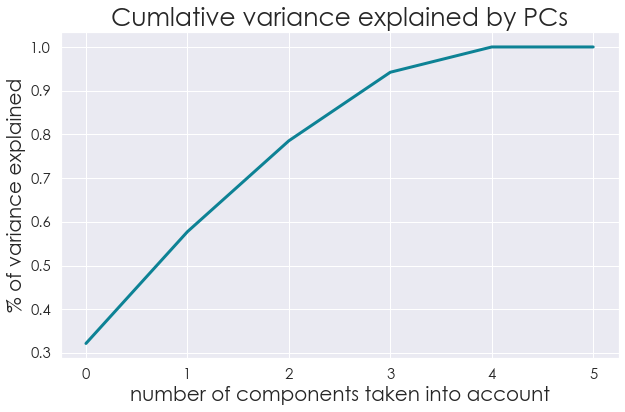

In [29]:
set_style_pers()
sns.lineplot(x=[_ for _ in range(6)], y=var)
plt.title("Cumlative variance explained by PCs")
plt.ylabel("% of variance explained")
plt.xlabel("number of components taken into account")
;

In [ ]:
# convert the spark dataframe to pd.DataFrame and save it as csv locally
pd_transformed = transformed.select("path", "label", "pca").toPandas()
pd_transformed.to_csv("C:/Users/VP/Documents/OC/P8/pca_features.csv")